In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func
from datetime import datetime, timedelta

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find most recent
recentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recentdate)

2017-08-23


Text(0, 0.5, 'mm')


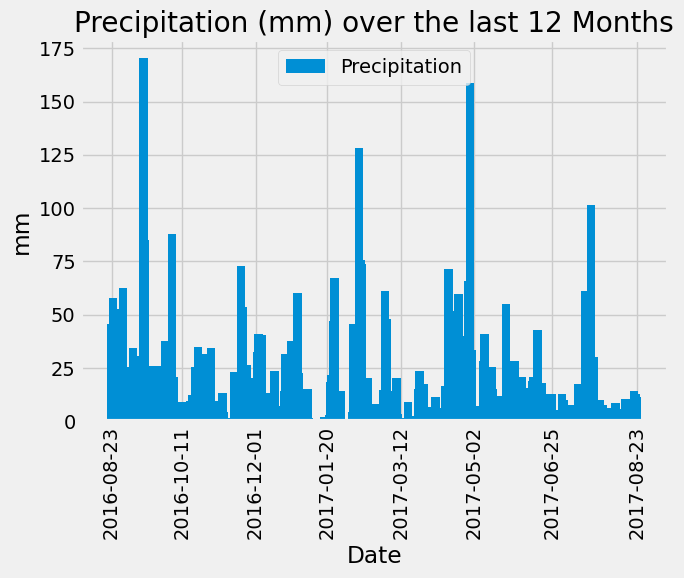

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
currentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
yearold = pd.to_datetime(currentdate) - pd.DateOffset(years=1)
yearoldStime = yearold.strftime('%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yearoldStime).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_dFrame = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
precip_dFrame = precip_dFrame.sort_values(by='Date')
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7, 6))
plt.bar(precip_dFrame['Date'], precip_dFrame['Precipitation'], width=6, label='Precipitation') 
step = len(precip_dFrame) // 7
plt.xticks(precip_dFrame['Date'][::step], rotation=90)
plt.yticks(range(0, 176, 25))
plt.legend(loc='upper center')
plt.xlabel("Date")
plt.ylabel("mm")
plt.title("Precipitation (mm) over the last 12 Months")
plt.tight_layout()
print("Text(0, 0.5, 'mm')")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stat = pd.DataFrame(precip_dFrame['Precipitation'].describe())
# Print the summary statistics
sum_stat

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
numberofstations= session.query(Station).count()
print(numberofstations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stationlist=[ ] 
station_and_vists = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for station, count in station_and_vists:
     stationlist.append((station,count))
stationlist

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_and_vists = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station = station_and_vists[0][0]
count = station_and_vists[0][1]
temp= session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()
print(f"[({temp[0][0]},{temp[0][1]},{temp[0][2]})]")

[(12.2,29.4,22.03582251082252)]


Text(0.5, 4.183333333333314, 'Temperature')


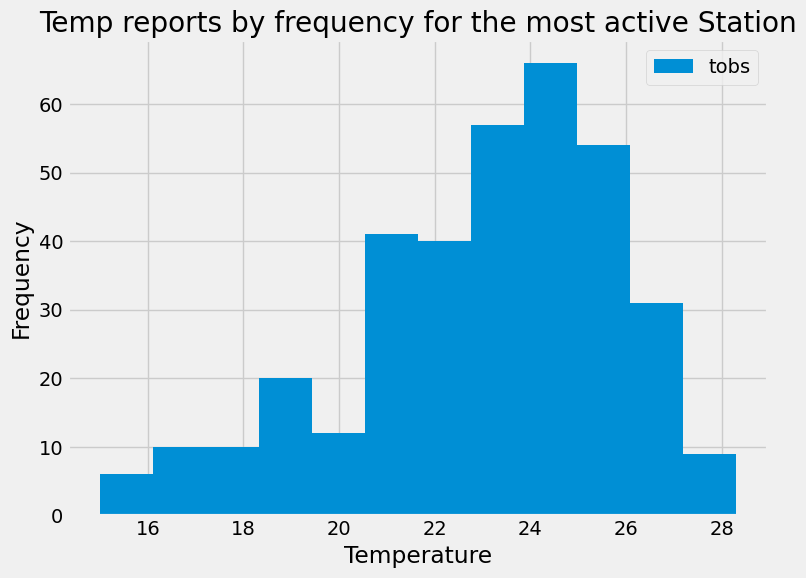

In [15]:
# Using the most active station id
#Query and obtain the most active station
station_and_vists = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_station = station_and_vists[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Newest_date = session.query(Measurement.date).filter(Measurement.station == active_station).order_by(Measurement.date.desc()).first()[0]
Newest_date = datetime.strptime(Newest_date, "%Y-%m-%d")
Nd_minus_year = Newest_date - timedelta(days=365)
#Query and obtain temperature data
Temp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= Nd_minus_year).filter(Measurement.station == active_station).all()
Temp_df = pd.DataFrame(Temp_data, columns=["Date", "Temperature"])
# histogram
plt.figure(figsize=(8, 6))
plt.hist(Temp_df["Temperature"], bins=12, alpha=1)
plt.title("Temp reports by frequency for the most active Station")
plt.legend(["tobs"])
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.tight_layout()
print("Text(0.5, 4.183333333333314, 'Temperature')")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()